## Masking and Patching

In [1]:
import jax
from jax import lax
from jax import numpy as jnp
import numpy as np
import einops
import equinox as eqx
import optax

import matplotlib.pyplot as plt

from jepax.data import build_dataset
dataloader, _, _, _ = build_dataset("CIFAR10", data_dir="~/data")

x, y = next(iter(dataloader))

/Users/anton/source/jepax/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


In [2]:
x.shape

(32, 32, 32, 3)

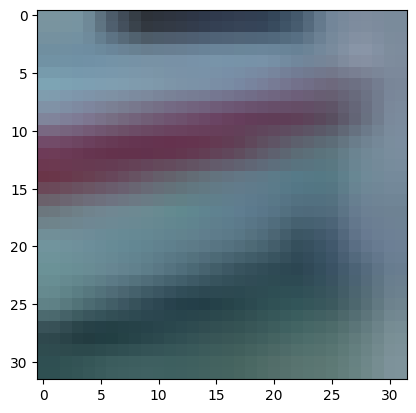

In [3]:
plt.imshow(x[0])

## 1. Patchifier + masking

In [4]:
def patchify(x, patch_size=2):
    return einops.rearrange(
        x,
        "(h ph) (w pw) c -> (h w) (c ph pw)",
        ph=patch_size,
        pw=patch_size,
    )

def unpatchify(x, patch_size=2, n_patch=16):
    return einops.rearrange(
        x,
        "(h w) (c ph pw) -> (h ph) (w pw) c",
        h=n_patch,
        ph=patch_size,
        pw=patch_size,
    )

x_patch = patchify(x[0])
x_patch.shape

(256, 12)

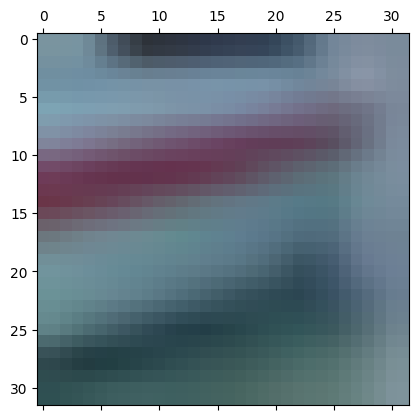

In [5]:
plt.matshow(unpatchify(x_patch))

In [6]:
from typing import Any
from functools import partial

class IJEPAMasker:
    def __init__(self, height, width, patch_size,
                 ctx_scale=(0.8, 1.0), ctx_aspect=1.0,
                 pred_scale=(0.15, 0.2), pred_aspect=(0.75, 1.5)):
        self.h = height
        self.w = width
        self.ps = patch_size


        self.h_patch = self.h // self.ps
        self.w_patch = self.w // self.ps

        self.ctx_scale = self._create_interval(ctx_scale)
        self.ctx_aspect = self._create_interval(ctx_aspect)
        self.pred_scale = self._create_interval(pred_scale)
        self.pred_aspect = self._create_interval(pred_aspect)

    def _get_idx_mask(self, scale, aspect):
        # (i, j) indices for top left corner
        i_max = jnp.ceil((1 - scale) * self.w // 2) 
        j_max = jnp.ceil((1 - scale / aspect) * self.h // 2) 
        pw_mask = jnp.array(self.w * scale // self.ps, int)
        ph_mask = jnp.array(self.w * scale * aspect // self.ps, int)
        return i_max, j_max, pw_mask, ph_mask
    
    def _create_interval(self, x):
        return x if isinstance(x, tuple) else (x, x)
        
    def _sample(self, key, interval):
        return jax.random.uniform(key, minval=interval[0], maxval=interval[1])
    
    def _sample_aspects(self, key):
        k1, k2, k3, k4 = jax.random.split(key, 4)
        ctx_scale = self._sample(k1, self.ctx_scale)
        ctx_aspect = self._sample(k2, self.ctx_aspect)
        pred_scale = self._sample(k3, self.pred_scale)
        pred_aspect = self._sample(k4, self.pred_aspect)
        return ctx_scale, ctx_aspect, pred_scale, pred_aspect
    
    def _sample_mask(self, key, i_max, j_max, pw_mask, ph_mask):
        k1, k2 = jax.random.split(key, 2)
        i = jax.random.randint(k1, (), minval=0, maxval=i_max)
        j = jax.random.randint(k2, (), minval=0, maxval=j_max)

        ii, jj = jnp.meshgrid(jnp.arange(self.h_patch), jnp.arange(self.w_patch), indexing='ij')
        mask = (ii >= i) & (ii < i + ph_mask) & (jj >= j) & (jj < j + pw_mask)

        return mask
        
    def __call__(self, key, M):
        """

        Args:
            key (Key): RNG key for mask sampling
            M (int): Number of prediction masks

        Returns:
            Masks of shape (self.h_patch, self.w_patch), (M, self.h_patch, self.w_patch)
        """
        keys = jax.random.split(key, M+2)
        k1, k2, pred_keys = keys[0], keys[1], keys[2:]  # pred_keys is already (M, 2)

        ctx_scale, ctx_aspect, pred_scale, pred_aspect = self._sample_aspects(k1)

        print(
            pred_scale
        )

        ctx_mask = self._sample_mask(k2, *self._get_idx_mask(ctx_scale, ctx_aspect))
        pred_mask = jax.vmap(self._sample_mask, in_axes=(0, None, None, None, None))(
            pred_keys, *self._get_idx_mask(pred_scale, pred_aspect)
        )

        return ctx_mask, pred_mask
    

def visualize_mask(x, mask):
    mask = ~mask.flatten()
    x_masked = jax.vmap(lambda x, m: x * m)(patchify(x), mask)
    x_masked_img = unpatchify(x_masked)
    return x_masked_img

In [36]:
masker = IJEPAMasker(32, 32, 2, ctx_scale=0.9, pred_scale=0.175, pred_aspect=1.0)

@partial(jax.jit, static_argnums=(1,))
def create_mask(key, M):
    return masker(key, M)

mask_ctx, mask_pred = create_mask(jax.random.PRNGKey(0), 4)

JitTracer<float32[]>


In [37]:
len(mask_pred)

4

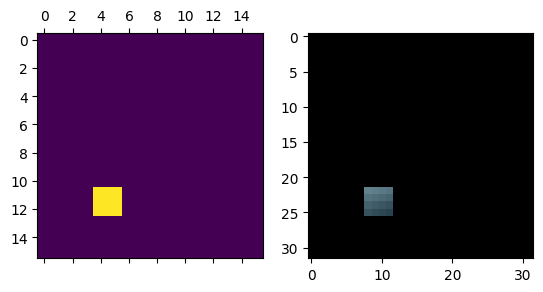

In [38]:
fig, ax = plt.subplots(1,2)
mask_plt = mask_pred[2]
ax[0].matshow(mask_plt)
ax[1].imshow(visualize_mask(x[0], ~mask_plt))

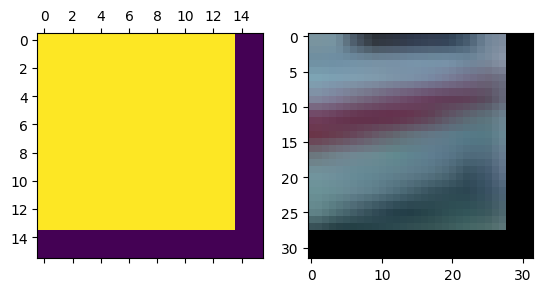

In [39]:
fig, ax = plt.subplots(1,2)
ax[0].matshow(mask_ctx)
ax[1].imshow(visualize_mask(x[0], ~mask_ctx))

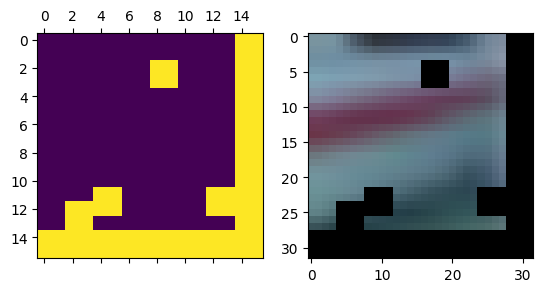

In [40]:
mask_total = ~mask_ctx | jnp.any(mask_pred, axis=0)

fig, ax = plt.subplots(1,2)
ax[0].matshow(mask_total)
ax[1].imshow(visualize_mask(x[0], mask_total))

### Setting Patches

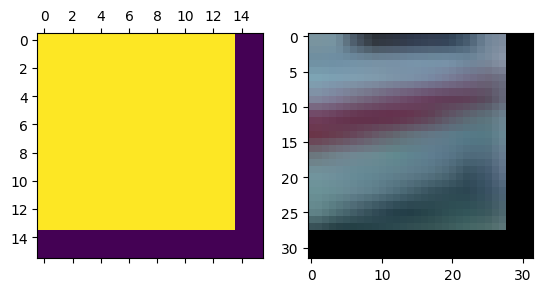

In [41]:
x_patch = patchify(x[0])

fig, ax = plt.subplots(1,2)
ax[0].matshow(mask_ctx)
ax[1].imshow(visualize_mask(x[0], ~mask_ctx))

In [42]:
x_patch.shape

(256, 12)

In [43]:
mask_ctx.flatten()[0]

Array(True, dtype=bool)

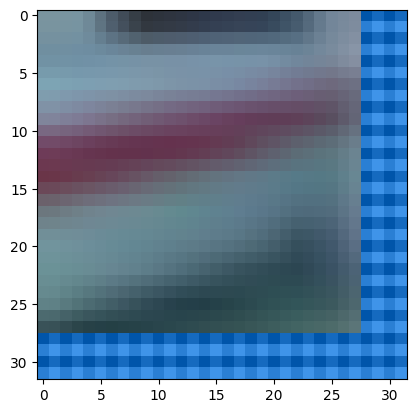

In [44]:
def set_mask(x, mask, vec):
    return x * mask + (1 - mask) * vec

v = jnp.arange(0, 12) / 12

x_patch_set = jax.vmap(set_mask, in_axes=(0, 0, None))(x_patch, mask_ctx.flatten(), v)

plt.imshow(unpatchify(x_patch_set))